In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse.csgraph as csg
from scipy.special import erf
from time import time
matplotlib.rcParams['figure.figsize'] = [7,7]
def gcum(z):
    return (1 + erf(z/np.sqrt(2))) * 0.5

In [15]:
dim = 15
prefix="20000-fp0.05-qs0.9"
grid = np.loadtxt(prefix+".grid")[:]
refgrid = np.asarray(np.loadtxt("ref.idxs"),int)-1
x = np.loadtxt("traj9.proj")[refgrid]
ni = np.asarray(grid[:,dim],int)-1
pi = grid[:,dim+1]
ei = grid[:,dim+2]
ncls = np.max(ni)+1
ngrid = len(ni)

In [16]:
print ngrid

20000


In [17]:
lcls = []
Qi = np.zeros(ncls)
for i in xrange(ncls):
    icls = np.where(ni == i)[0]
    Qi[i] = np.exp(pi[icls]).sum()
    lcls.append(icls)

In [18]:
nbs = 64
nibs = np.zeros((nbs,ngrid),int)
nclsbs = np.zeros(nbs,int)
for bs in xrange(nbs):
    idx = "%03d" % (bs+1)
    nibs[bs] = np.asarray(np.loadtxt(prefix+"-bs-bs"+idx+".grid")[:,dim],int) - 1
    nclsbs[bs] = np.max(nibs[bs])+1

In [12]:
np.savetxt('%s.%s' % (prefix,'bs'),nibs,fmt='%d')

In [19]:
QA = np.zeros((nbs,np.max(nclsbs)))
for bs in xrange(nbs):
    for i in xrange(nclsbs[bs]):
        icls = np.where(nibs[bs] == i)[0]
        QA[bs,i] = np.exp(pi[icls]).sum()

In [20]:
QAi = np.zeros((nbs,np.max(nclsbs),ncls))
for bs in xrange(nbs):
    for i in xrange(nclsbs[bs]):
        icls = np.where(nibs[bs] == i)[0]
        for j in xrange(ncls):
            inter = np.intersect1d(icls, lcls[j])
            QAi[bs,i,j] = np.exp(pi[inter]).sum()

In [21]:
aij = np.zeros((ncls,ncls))
for i in xrange(ncls):
    for j in xrange(i+1):
        tij = 0
        for bs in xrange(nbs):
            for k in xrange(nclsbs[bs]):
                tij += QAi[bs,k,i] * QAi[bs,k,j]
        aij[i,j] = aij[j,i] = tij/(Qi[i]*Qi[j]*nbs)
print aij.diagonal()
da=aij.diagonal()
gij=aij / np.sqrt(np.multiply.outer(da,da))

[ 0.95392381  0.99999996  0.82477068  0.94944465  0.87171236  0.82425797
  0.84374542  0.9599444   0.97541531  0.97925313  0.9099384   0.761367
  0.94412295  0.76615522  0.9843649   0.98833137]


In [9]:
bij = np.zeros((ncls,ncls))
for i in xrange(ncls):
    for j in xrange(i+1):        
        tij = 0
        for bs in xrange(nbs):
            for k in xrange(nclsbs[bs]):
                tij += QAi[bs,k,i] * QAi[bs,k,j] / (QA[bs,k] * QA[bs,k])                
        bij[i,j] = bij[j,i] = tij/nbs
print bij.diagonal()

[ 0.96673138  0.99999999  0.99672484  0.75833495  0.72853947  0.87881441
  0.66538676  1.          0.88431119  0.15310106]


In [22]:
nij = np.zeros((ncls,ncls))
for i in xrange(ncls):
    for j in xrange(i+1):        
        tij = 0
        for bs in xrange(nbs):
            for k in xrange(nclsbs[bs]):
                tij += QAi[bs,k,i] * QAi[bs,k,j] / (QA[bs,k])                
        nij[i,j] = nij[j,i] = tij/nbs
nij /= np.exp(pi).sum()
py = np.zeros(ncls)
for i in xrange(ncls):
    py[i] = np.exp(pi[lcls[i]]).sum()
py/=np.exp(pi).sum()

In [23]:
nnij = nij/ np.sqrt(np.multiply.outer(py,py))
print nnij.diagonal()

[ 0.6882592   0.99999998  0.8778337   0.89638854  0.84776703  0.83857607
  0.90205686  0.98090058  0.94264377  0.98895874  0.79692216  0.80881466
  0.60166583  0.30974227  0.85547069  0.95779508]


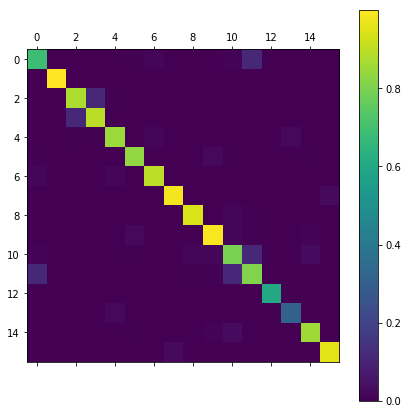

In [24]:
plt.matshow(nnij)
plt.colorbar()
plt.show()

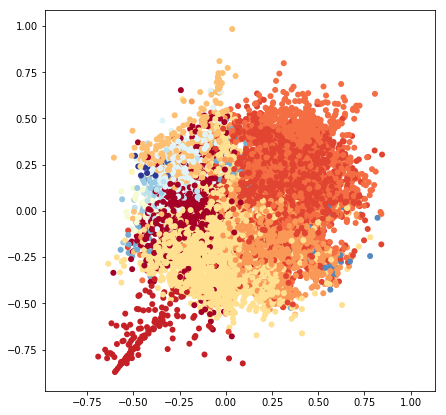

In [27]:
cm = plt.cm.get_cmap('RdYlBu')
plt.scatter(x[:,0],x[:,1],c=ni[:], linewidth='0', cmap=cm)
plt.axes().set_aspect('equal','datalim')
plt.show()

In [42]:
cij = nnij > 0.018
cgraph=csg.csgraph_from_dense(cij, null_value=False)
cc=csg.connected_components(cgraph)
print cc[0]

8


In [43]:
macro = []
imacro = np.ones(ngrid,int)*-1
for i in xrange(cc[0]):
    mci = np.zeros(0,int)
    for j in xrange(ncls):
        if cc[1][j] == i:
            mci = np.union1d(mci, lcls[j])
            imacro[lcls[j]] = i
    macro.append(mci)

In [44]:
si = np.sqrt(np.exp(pi-pi.max()))

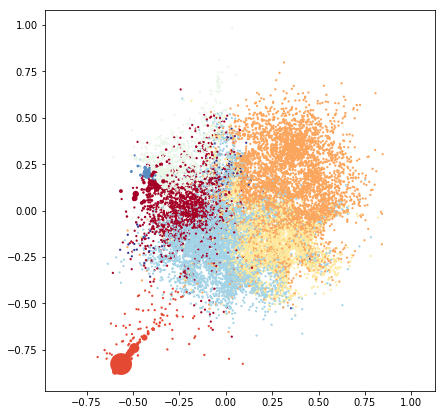

In [45]:
plt.scatter(x[:,0],x[:,1],c=imacro, s=(5+si*500), linewidth='0',cmap=cm)
plt.axes().set_aspect('equal','datalim')
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


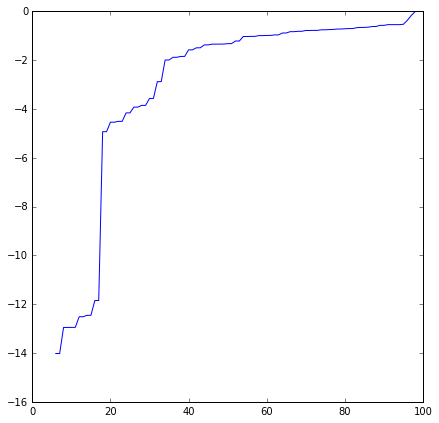

In [154]:
plt.plot(np.log10(np.sort(aij.flatten())))
plt.show()

In [156]:
np.where(imacro>0)

(array([40]),)

In [54]:
gij.diagonal()

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [157]:
x[40]

array([ 0.84103202, -0.18146849])